<a href="https://colab.research.google.com/github/mthuy04/mthuy04.github.io/blob/main/testThuy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#CÀI ĐẶT CÁC THAM SỐ ---
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS_INITIAL = 20
EPOCHS_FINE_TUNE = 30
LEARNING_RATE_INITIAL = 1e-3
LEARNING_RATE_FINE_TUNE = 1e-5

In [ ]:
# Đường dẫn
DRIVE_PATH = '/content/drive/MyDrive/'
CSV_FILE_PATH = os.path.join(DRIVE_PATH, 'test tiếp.csv')
IMAGE_DATA_DIR = os.path.join(DRIVE_PATH, 'Dataset_Gender_Age')

In [ ]:
AGE_CLASSES = ['Child', 'Teen', 'Adult', 'Elderly']
GENDER_CLASSES = ['Male', 'Female']

In [ ]:
# Đọc file CSV
try:
    df = pd.read_csv(CSV_FILE_PATH)
    print(f"Tải thành công file CSV. Số lượng mẫu: {len(df)}")
    print(df.head(20))
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file CSV tại: {CSV_FILE_PATH}")
    exit()

Tải thành công file CSV. Số lượng mẫu: 4200
                                                image  gender age group
0   /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
1   /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
2   /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
3   /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
4   /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
5   /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
6   /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
7   /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
8   /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
9   /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
10  /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
11  /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child
12  /content/drive/M

In [ ]:
df['image_path'] = df['image']

In [ ]:
# Hiển thị thông tin cơ bản của dataframe
print("Thông tin DataFrame:")
print(df.info())
print("\nMột vài dòng đầu của DataFrame:")
print(df.head())
print(f"\nSố lượng mẫu: {len(df)}")
print("\nPhân phối giới tính:")
print(df['gender'].value_counts())
print("\nPhân phối nhóm tuổi:")
print(df['age group'].value_counts())

# Kiểm tra xem có giá trị null không
print("\nKiểm tra giá trị null:")
print(df.isnull().sum())

Thông tin DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       4200 non-null   object
 1   gender      4200 non-null   object
 2   age group   4200 non-null   object
 3   image_path  4200 non-null   object
dtypes: object(4)
memory usage: 131.4+ KB
None

Một vài dòng đầu của DataFrame:
                                               image  gender age group  \
0  /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child   
1  /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child   
2  /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child   
3  /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child   
4  /content/drive/MyDrive/Dataset_Gender_Age/Chil...  Female     Child   

                                          image_path  
0  /content/drive/MyDrive/Dataset_Gender_Age/Chil... 

In [ ]:
import os
import pandas as pd

# Đường dẫn tới file CSV chứa thông tin dữ liệu
CSV_FILE_PATH = '/content/drive/MyDrive/test tiếp.csv'

# Đọc dữ liệu từ file CSV
df = pd.read_csv(CSV_FILE_PATH)

# Giả sử cột chứa đường dẫn ảnh có tên là 'image'
image_paths = df['image'].tolist()

# Danh sách để lưu các đường dẫn không hợp lệ
invalid_paths = []

# Kiểm tra từng đường dẫn
for path in image_paths:
    if not os.path.exists(path):
        invalid_paths.append(path)

# Hiển thị kết quả
if invalid_paths:
    print("Các đường dẫn ảnh không hợp lệ:")
    for path in invalid_paths:
        print(path)
else:
    print("Tất cả các đường dẫn ảnh đều hợp lệ.")

Tất cả các đường dẫn ảnh đều hợp lệ.


In [ ]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    def _load_and_process(image_path_val):
        # Chuyển đổi từ bytes sang chuỗi nếu cần
        if isinstance(image_path_val, bytes):
            image_path_str = image_path_val.decode("utf-8")
        else:
            image_path_str = image_path_val

        # Kiểm tra xem file có tồn tại không
        if not tf.io.gfile.exists(image_path_str):
            print(f"File does not exist: {image_path_str}")
            # Trả về ảnh placeholder (ảnh đen)
            return tf.zeros((target_size[0], target_size[1], IMAGE_CHANNELS), dtype=tf.float32)

        try:
            image = tf.io.read_file(image_path_str)
            image = tf.image.decode_image(image, channels=IMAGE_CHANNELS)
            # Nếu bạn muốn giữ tỷ lệ khung hình, sử dụng resize_with_pad để thêm padding sau khi resize
            image = tf.image.resize_with_pad(image, target_height=target_size[0], target_width=target_size[1])
            image = image / 255.0  # Chuẩn hóa pixel
            return image
        except Exception as e:
            print(f"Error processing image '{image_path_str}': {e}")
            return tf.zeros((target_size[0], target_size[1], IMAGE_CHANNELS), dtype=tf.float32)

    image = tf.py_function(_load_and_process, [image_path], tf.float32)
    image.set_shape((target_size[0], target_size[1], IMAGE_CHANNELS))
    return image

In [ ]:
# Mã hóa nhãn
# Giới tính:
gender_encoder = LabelEncoder()
df['gender_encoded'] = gender_encoder.fit_transform(df['gender'])
print("\nCác lớp giới tính sau mã hóa:", gender_encoder.classes_) # Sẽ là [0, 1] hoặc ['Female', 'Male'] tùy theo dữ liệu

gender_one_hot_encoder = OneHotEncoder(sparse_output=False)
gender_labels_one_hot = gender_one_hot_encoder.fit_transform(df['gender_encoded'].values.reshape(-1, 1))
print("Ví dụ nhãn giới tính one-hot:", gender_labels_one_hot[:5])

# Nhóm tuổi
age_encoder = LabelEncoder()
df['age_group_encoded'] = age_encoder.fit_transform(df['age group'])
print("\nCác lớp nhóm tuổi sau mã hóa:", age_encoder.classes_) # ['Adult', 'Child', 'Elderly', 'Teenager'] (thứ tự tùy thuộc vào dữ liệu)

age_one_hot_encoder = OneHotEncoder(sparse_output=False)
age_labels_one_hot = age_one_hot_encoder.fit_transform(df['age_group_encoded'].values.reshape(-1, 1))
print("Ví dụ nhãn nhóm tuổi one-hot:", age_labels_one_hot[:5])



Các lớp giới tính sau mã hóa: ['Female' 'Male']
Ví dụ nhãn giới tính one-hot: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]

Các lớp nhóm tuổi sau mã hóa: ['Adult' 'Child' 'Elderly' 'Teen']
Ví dụ nhãn nhóm tuổi one-hot: [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [ ]:
# Chuẩn bị danh sách đường dẫn ảnh và nhãn

import re
def clean_path(path: str) -> str:
    return path
# Nếu trong file CSV cột chứa đường dẫn ảnh được đặt tên là 'image'
raw_image_paths = df['image'].tolist()

# Áp dụng hàm clean_path cho từng đường dẫn để tạo danh sách image_paths hợp lệ
image_paths = [clean_path(path) for path in raw_image_paths]

# Chuẩn bị nhãn
gender_labels_binary = df['gender_encoded'].values  # Sử dụng trực tiếp 0 hoặc 1
labels_gender = gender_labels_binary
labels_age = age_labels_one_hot  # Sử dụng one-hot encoding cho nhãn nhóm tuổi

In [ ]:
# Tỉ lệ: 70% train, 15% validation, 15% test
X_train_paths, X_temp_paths, y_train_gender, y_temp_gender, y_train_age, y_temp_age = train_test_split(
    image_paths, labels_gender, labels_age, test_size=0.3, random_state=42, stratify=df['age_group_encoded'] # Stratify theo tuổi để đảm bảo phân bố
)
X_val_paths, X_test_paths, y_val_gender, y_test_gender, y_val_age, y_test_age = train_test_split(
    X_temp_paths, y_temp_gender, y_temp_age, test_size=0.5, random_state=42, stratify=y_temp_age.argmax(axis=1) if y_temp_age.ndim > 1 else y_temp_age
)

print(f"\nKích thước tập huấn luyện: {len(X_train_paths)}")
print(f"Kích thước tập kiểm định: {len(X_val_paths)}")
print(f"Kích thước tập kiểm thử: {len(X_test_paths)}")


Kích thước tập huấn luyện: 2940
Kích thước tập kiểm định: 630
Kích thước tập kiểm thử: 630


In [ ]:
def create_dataset(image_paths, gender_labels, age_labels, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, gender_labels, age_labels))

    # Ánh xạ qua hàm xử lý ảnh, có khả năng trả về None đối với mẫu lỗi
    def load_and_filter(image_path, gender_label, age_label):
        image = load_and_preprocess_image(image_path)
        return image, gender_label, age_label

    ds = ds.map(load_and_filter, num_parallel_calls=tf.data.AUTOTUNE)
    # Lọc bỏ mẫu có ảnh trả về None
    ds = ds.filter(lambda image, gender_label, age_label: image is not None)
    # Chuyển đổi cấu trúc dataset thành (image, {gender_output: ..., age_output: ...})
    ds = ds.map(
        lambda image, gender_label, age_label: (
            image, {
                "gender_output": tf.cast(gender_label, tf.float32),
                "age_output": tf.cast(age_label, tf.float32)
            }
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.shuffle(buffer_size=len(image_paths))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [ ]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    def _load_and_process(image_path_val):
        # Convert tensor or numpy type to a native Python string.
        if isinstance(image_path_val, tf.Tensor):
            image_path_val = image_path_val.numpy()  # Convert EagerTensor to numpy
        if isinstance(image_path_val, bytes):
            image_path_str = image_path_val.decode("utf-8")
        elif isinstance(image_path_val, str):
            image_path_str = image_path_val
        else:
            image_path_str = str(image_path_val)

        # Check if the file exists using a native Python string path.
        if not tf.io.gfile.exists(image_path_str):
            print(f"File does not exist: {image_path_str}")
            # Return a placeholder (black image) if the file is not found.
            return tf.zeros((target_size[0], target_size[1], IMAGE_CHANNELS), dtype=tf.float32)

        try:
            image = tf.io.read_file(image_path_str)
            image = tf.image.decode_image(image, channels=IMAGE_CHANNELS)
            # Using resize_with_pad to maintain aspect ratio and pad to meet the target size.
            image = tf.image.resize_with_pad(image, target_height=target_size[0], target_width=target_size[1])
            image = image / 255.0  # Normalize pixel values.
            return image
        except Exception as e:
            print(f"Error processing image '{image_path_str}': {e}")
            return tf.zeros((target_size[0], target_size[1], IMAGE_CHANNELS), dtype=tf.float32)

    image = tf.py_function(_load_and_process, [image_path], tf.float32)
    image.set_shape((target_size[0], target_size[1], IMAGE_CHANNELS))
    return image

In [ ]:
train_dataset = create_dataset(X_train_paths, y_train_gender, y_train_age, BATCH_SIZE)
val_dataset = create_dataset(X_val_paths, y_val_gender, y_val_age, BATCH_SIZE)
test_dataset = create_dataset(X_test_paths, y_test_gender, y_test_age, BATCH_SIZE)

Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Male/001664.jpg': {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Male/001559.jpg': {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Male/001563.jpg': {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Female/001636.jpg': {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Un

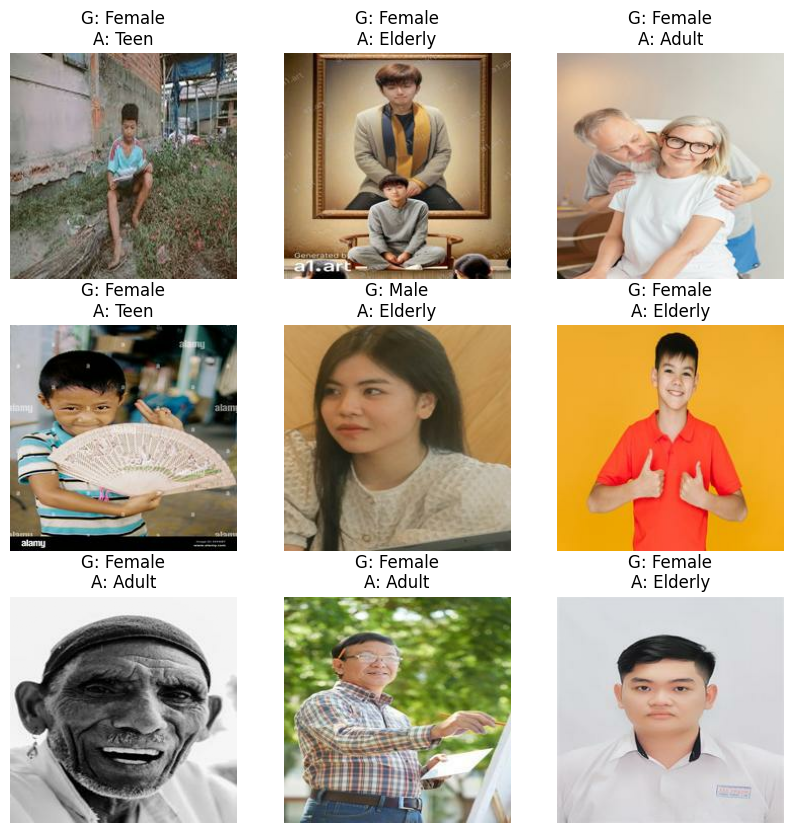

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Kiểm tra một batch dữ liệu từ train_dataset
for images, labels in train_dataset.take(1):
    print("\nShapes của một batch dữ liệu huấn luyện:")
    print("Images shape:", images.shape)
    print("Gender labels shape:", labels['gender_output'].shape)
    print("Age labels shape:", labels['age_output'].shape)

    # Hiển thị một vài ảnh ví dụ
    plt.figure(figsize=(10, 10))
    for i in range(min(9, images.shape[0])):  # Hiển thị tối đa 9 ảnh
        ax = plt.subplot(3, 3, i + 1)
        # Chuyển tensor ảnh sang numpy array
        image_np = images[i].numpy()
        plt.imshow(image_np)

        # Nếu sử dụng sigmoid cho output của giới tính
        gender_pred_idx = int(round(labels['gender_output'][i].numpy()))
        # Với output của nhóm tuổi là one-hot encoding
        age_pred_idx = int(np.argmax(labels['age_output'][i].numpy()))

        plt.title(f"G: {GENDER_CLASSES[gender_pred_idx]}\nA: {AGE_CLASSES[age_pred_idx]}")
        plt.axis("off")
    plt.show()
    break

In [ ]:
# --- 3. XÂY DỰNG MÔ HÌNH ResNet50 ---
def build_resnet50_model(image_size=IMAGE_SIZE, num_age_classes=len(AGE_CLASSES)):
    # Tải ResNet50 pre-trained trên ImageNet, không bao gồm lớp fully connected ở trên cùng
    base_model = ResNet50(weights='imagenet', include_top=False,
                          input_shape=(image_size[0], image_size[1], IMAGE_CHANNELS))

    # Đóng băng các lớp của base_model để không huấn luyện lại trong giai đoạn đầu
    base_model.trainable = False

    # Xây dựng phần đầu của mô hình (custom head)
    inputs = Input(shape=(image_size[0], image_size[1], IMAGE_CHANNELS))
    x = base_model(inputs, training=False) # Quan trọng: training=False khi base_model bị đóng băng
    x = GlobalAveragePooling2D(name='avg_pool')(x)

    # Nhánh cho Nhóm tuổi (Age)
    age_branch = Dense(256, activation='relu', name='age_dense_1')(x)
    age_branch = BatchNormalization(name='age_bn_1')(age_branch)
    age_branch = Dropout(0.5, name='age_dropout_1')(age_branch) # Dropout để chống overfitting
    age_branch = Dense(128, activation='relu', name='age_dense_2')(age_branch)
    age_branch = BatchNormalization(name='age_bn_2')(age_branch)
    age_branch = Dropout(0.3, name='age_dropout_2')(age_branch)
    age_output = Dense(num_age_classes, activation='softmax', name='age_output')(age_branch)

    # Nhánh cho Giới tính (Gender)
    gender_branch = Dense(128, activation='relu', name='gender_dense_1')(x) # Có thể dùng ít lớp hơn cho gender
    gender_branch = BatchNormalization(name='gender_bn_1')(gender_branch)
    gender_branch = Dropout(0.5, name='gender_dropout_1')(gender_branch)
    # Sử dụng 1 unit với sigmoid cho binary classification (Male/Female)
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_branch)
    # Hoặc 2 units với softmax nếu bạn mã hóa one-hot cho gender
    # gender_output = Dense(2, activation='softmax', name='gender_output')(gender_branch)


    # Tạo mô hình với 1 đầu vào và 2 đầu ra
    model = Model(inputs=inputs, outputs=[gender_output, age_output], name="ResNet50_Gender_Age")

    return model

model = build_resnet50_model()
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ResNet50_Gender_Age"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_pool            │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_dense_1 (Dense) │ (None, 256)       │    524,544 │ avg_pool[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_bn_1            │ (None, 256)       │      1,024 │ age_dense_1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_dropout_1       │ (None, 256)       │          0 │ age_bn_1[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_dense_1      │ (None, 128)       │    262,272 │ avg_pool[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_dense_2 (Dense) │ (None, 128)       │     32,896 │ age_dropout_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_bn_1         │ (None, 128)       │        512 │ gender_dense_1[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_bn_2            │ (None, 128)       │        512 │ age_dense_2[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_dropout_1    │ (None, 128)       │          0 │ gender_bn_1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_dropout_2       │ (None, 128)       │          0 │ age_bn_2[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        129 │ gender_dropout_1… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 4)         │        516 │ age_dropout_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,410,117 (93.12 MB)

 Trainable params: 821,381 (3.13 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [ ]:
# Compile mô hình
# Định nghĩa losses và loss_weights
losses = {
    "gender_output": "binary_crossentropy", # Vì gender_output dùng sigmoid (1 unit)
    # "gender_output": "categorical_crossentropy", # Nếu gender_output dùng softmax (2 units)
    "age_output": "categorical_crossentropy"  # Vì age_output dùng softmax (4 units)
}
loss_weights = {"gender_output": 0.5, "age_output": 0.5} # Có thể điều chỉnh trọng số

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_INITIAL),
              loss=losses,
              loss_weights=loss_weights,
              metrics={
                  "gender_output": "accuracy", # Hoặc tf.keras.metrics.BinaryAccuracy()
                  "age_output": "accuracy"   # Hoặc tf.keras.metrics.CategoricalAccuracy()
              })


In [ ]:
# --- 4. HUẤN LUYỆN GIAI ĐOẠN 1 (CHỈ HUẤN LUYỆN CÁC LỚP MỚI) ---
print("\n--- BẮT ĐẦU HUẤN LUYỆN GIAI ĐOẠN 1 (TRANSFER LEARNING) ---")

# Callbacks
checkpoint_path_initial = os.path.join(DRIVE_PATH, "resnet50_gender_age_initial_best.keras") #Lưu dưới dạng .keras
model_checkpoint_initial = ModelCheckpoint(filepath=checkpoint_path_initial,
                                           save_best_only=True,
                                           monitor='val_age_output_accuracy', # Theo dõi accuracy của nhánh tuổi trên tập val
                                           mode='max',
                                           verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', # Theo dõi tổng loss trên tập val
                               patience=10, # Dừng nếu không cải thiện sau 10 epochs
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, # Giảm LR đi 5 lần
                              patience=5,
                              verbose=1,
                              mode='min',
                              min_lr=1e-7)

history_initial = model.fit(
    train_dataset,
    epochs=EPOCHS_INITIAL,
    validation_data=val_dataset,
    callbacks=[model_checkpoint_initial, early_stopping, reduce_lr]
)

# Tải lại trọng số tốt nhất từ giai đoạn 1
# model.load_weights(checkpoint_path_initial) # Đã có restore_best_weights=True trong EarlyStopping



--- BẮT ĐẦU HUẤN LUYỆN GIAI ĐOẠN 1 (TRANSFER LEARNING) ---
Epoch 1/20
Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Male/001664.jpg': {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Male/001559.jpg': {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Male/001563.jpg': {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Female/001636.jpg': {{function_node __wrappe

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Male/002051.jpg': {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Male/002150.jpg': {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Male/002046.jpg': {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Error processing image '/content/drive/MyDrive/Dataset_Gender_Age/Adult/Male/001590.jpg': {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unkn

In [ ]:
# --- 5. FINE-TUNING (MỞ BĂNG MỘT PHẦN HOẶC TOÀN BỘ ResNet50) ---
print("\n--- BẮT ĐẦU HUẤN LUYỆN GIAI ĐOẠN 2 (FINE-TUNING) ---")

base_model = model.get_layer('resnet50') # Lấy lại base_model từ mô hình đã xây dựng
base_model.trainable = True

for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

# Re-compile mô hình với learning rate nhỏ hơn nhiều cho fine-tuning
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_FINE_TUNE), # LR rất nhỏ
              loss=losses,
              loss_weights=loss_weights,
              metrics={
                  "gender_output": "accuracy",
                  "age_output": "accuracy"
              })

model.summary() # Xem lại các lớp trainable

# Callbacks cho fine-tuning
checkpoint_path_fine_tune = os.path.join(DRIVE_PATH, "resnet50_gender_age_fine_tune_best.keras")
model_checkpoint_fine_tune = ModelCheckpoint(filepath=checkpoint_path_fine_tune,
                                             save_best_only=True,
                                             monitor='val_age_output_accuracy',
                                             mode='max',
                                             verbose=1)
# Có thể dùng lại early_stopping và reduce_lr đã định nghĩa ở trên, hoặc tạo mới với patience khác
early_stopping_ft = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)
reduce_lr_ft = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, verbose=1, mode='min', min_lr=1e-8)


history_fine_tune = model.fit(
    train_dataset,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=val_dataset,
    callbacks=[model_checkpoint_fine_tune, early_stopping_ft, reduce_lr_ft],
    initial_epoch=history_initial.epoch[-1] # Tiếp tục từ epoch cuối của giai đoạn 1 (nếu muốn)
)

# Tải lại trọng số tốt nhất từ giai đoạn fine-tuning
model.load_weights(checkpoint_path_fine_tune)


In [ ]:
# --- 6. ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP TEST ---
print("\n--- ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP KIỂM THỬ ---")
results = model.evaluate(test_dataset, verbose=1)

print("\nKết quả đánh giá trên tập Test:")
print(f"Total Loss: {results[0]:.4f}")
print(f"Gender Loss: {results[1]:.4f} - Gender Accuracy: {results[3]:.4f}") # Index có thể thay đổi, kiểm tra model.metrics_names
print(f"Age Loss: {results[2]:.4f} - Age Accuracy: {results[4]:.4f}")
# In ra model.metrics_names để biết đúng index của từng metric
print("Model metrics names:", model.metrics_names)


# Lấy dự đoán trên tập test để xem xét chi tiết hơn
y_pred_test = model.predict(test_dataset)
y_pred_gender_proba = y_pred_test[0] # Xác suất cho gender
y_pred_age_proba = y_pred_test[1]    # Xác suất cho age

# Chuyển đổi xác suất thành nhãn lớp
y_pred_gender_classes = (y_pred_gender_proba > 0.5).astype("int32").flatten() # Ngưỡng 0.5 cho sigmoid
# y_pred_gender_classes = np.argmax(y_pred_gender_proba, axis=1) # Nếu gender dùng softmax
y_pred_age_classes = np.argmax(y_pred_age_proba, axis=1)

# Lấy nhãn thực tế từ test_dataset (cần phải lặp q///////ua dataset để lấy hết)
y_true_gender = []
y_true_age = []
for _, labels_batch in test_dataset:
    y_true_gender.extend(labels_batch['gender_output'].numpy().flatten().astype(int))
    y_true_age.extend(np.argmax(labels_batch['age_output'].numpy(), axis=1))

y_true_gender = np.array(y_true_gender)
y_true_age = np.array(y_true_age)



In [ ]:
# Báo cáo phân loại và Ma trận nhầm lẫn
print("\n--- BÁO CÁO PHÂN LOẠI CHO GIỚI TÍNH ---")
print(classification_report(y_true_gender, y_pred_gender_classes, target_names=GENDER_CLASSES))
cm_gender = confusion_matrix(y_true_gender, y_pred_gender_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues', xticklabels=GENDER_CLASSES, yticklabels=GENDER_CLASSES)
plt.title('Confusion Matrix - Gender')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n--- BÁO CÁO PHÂN LOẠI CHO NHÓM TUỔI ---")
# Đảm bảo target_names khớp với thứ tự của age_encoder.classes_
print(classification_report(y_true_age, y_pred_age_classes, target_names=age_encoder.classes_))
cm_age = confusion_matrix(y_true_age, y_pred_age_classes)
plt.figure(figsize=(8, 7))
sns.heatmap(cm_age, annot=True, fmt='d', cmap='Blues', xticklabels=age_encoder.classes_, yticklabels=age_encoder.classes_)
plt.title('Confusion Matrix - Age Group')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# --- 7. VẼ BIỂU ĐỒ QUÁ TRÌNH HUẤN LUYỆN ---
def plot_training_history(history1, history2=None, stage1_name="Initial Training", stage2_name="Fine-tuning"):
    acc_gender_initial = history1.history['gender_output_accuracy']
    val_acc_gender_initial = history1.history['val_gender_output_accuracy']
    loss_gender_initial = history1.history['gender_output_loss'] # Hoặc 'loss' nếu chỉ có 1 loss
    val_loss_gender_initial = history1.history['val_gender_output_loss'] # Hoặc 'val_loss'

    acc_age_initial = history1.history['age_output_accuracy']
    val_acc_age_initial = history1.history['val_age_output_accuracy']
    loss_age_initial = history1.history['age_output_loss']
    val_loss_age_initial = history1.history['val_age_output_loss']

    epochs_range_initial = range(len(acc_gender_initial))

    plt.figure(figsize=(20, 12))

    # Gender Accuracy - Giai đoạn 1
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range_initial, acc_gender_initial, label=f'{stage1_name} Gender Training Acc')
    plt.plot(epochs_range_initial, val_acc_gender_initial, label=f'{stage1_name} Gender Validation Acc')
    if history2:
        acc_gender_ft = history2.history['gender_output_accuracy']
        val_acc_gender_ft = history2.history['val_gender_output_accuracy']
        epochs_range_ft = range(len(acc_gender_initial), len(acc_gender_initial) + len(acc_gender_ft))
        plt.plot(epochs_range_ft, acc_gender_ft, label=f'{stage2_name} Gender Training Acc')
        plt.plot(epochs_range_ft, val_acc_gender_ft, label=f'{stage2_name} Gender Validation Acc')
    plt.legend(loc='lower right')
    plt.title('Gender Training and Validation Accuracy')

    # Gender Loss - Giai đoạn 1
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range_initial, loss_gender_initial, label=f'{stage1_name} Gender Training Loss')
    plt.plot(epochs_range_initial, val_loss_gender_initial, label=f'{stage1_name} Gender Validation Loss')
    if history2:
        loss_gender_ft = history2.history['gender_output_loss']
        val_loss_gender_ft = history2.history['val_gender_output_loss']
        epochs_range_ft = range(len(loss_gender_initial), len(loss_gender_initial) + len(loss_gender_ft))
        plt.plot(epochs_range_ft, loss_gender_ft, label=f'{stage2_name} Gender Training Loss')
        plt.plot(epochs_range_ft, val_loss_gender_ft, label=f'{stage2_name} Gender Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Gender Training and Validation Loss')

    # Age Accuracy - Giai đoạn 1
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range_initial, acc_age_initial, label=f'{stage1_name} Age Training Acc')
    plt.plot(epochs_range_initial, val_acc_age_initial, label=f'{stage1_name} Age Validation Acc')
    if history2:
        acc_age_ft = history2.history['age_output_accuracy']
        val_acc_age_ft = history2.history['val_age_output_accuracy']
        epochs_range_ft = range(len(acc_age_initial), len(acc_age_initial) + len(acc_age_ft))
        plt.plot(epochs_range_ft, acc_age_ft, label=f'{stage2_name} Age Training Acc')
        plt.plot(epochs_range_ft, val_acc_age_ft, label=f'{stage2_name} Age Validation Acc')
    plt.legend(loc='lower right')
    plt.title('Age Group Training and Validation Accuracy')

    # Age Loss - Giai đoạn 1
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range_initial, loss_age_initial, label=f'{stage1_name} Age Training Loss')
    plt.plot(epochs_range_initial, val_loss_age_initial, label=f'{stage1_name} Age Validation Loss')
    if history2:
        loss_age_ft = history2.history['age_output_loss']
        val_loss_age_ft = history2.history['val_age_output_loss']
        epochs_range_ft = range(len(loss_age_initial), len(loss_age_initial) + len(loss_age_ft))
        plt.plot(epochs_range_ft, loss_age_ft, label=f'{stage2_name} Age Training Loss')
        plt.plot(epochs_range_ft, val_loss_age_ft, label=f'{stage2_name} Age Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Age Group Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history_initial, history_fine_tune)

In [ ]:
# --- 8. LƯU MÔ HÌNH CUỐI CÙNG ---
final_model_path = os.path.join(DRIVE_PATH, "resnet50_gender_age_final_model.keras")
model.save(final_model_path)
print(f"\nMô hình cuối cùng đã được lưu tại: {final_model_path}")


In [ ]:
# --- 9. (TÙY CHỌN) DỰ ĐOÁN TRÊN ẢNH MỚI ---
def predict_single_image(image_path, model_loaded, age_encoder_classes, gender_classes_map):
    img = load_and_preprocess_image(image_path)
    if img is None:
        return None, None
    img_array = tf.expand_dims(img, 0) # Tạo batch dimension

    predictions = model_loaded.predict(img_array)
    gender_pred_proba = predictions[0][0][0] # Xác suất giới tính (sigmoid output)
    age_pred_proba = predictions[1][0]       # Mảng xác suất các nhóm tuổi

    gender_label = gender_classes_map[int(round(gender_pred_proba))]
    age_label = age_encoder_classes[np.argmax(age_pred_proba)]

    # Hiển thị ảnh và dự đoán
    plt.imshow(img.numpy())
    plt.title(f"Predicted Gender: {gender_label} ({gender_pred_proba:.2f})\nPredicted Age Group: {age_label} ({np.max(age_pred_proba):.2f})")
    plt.axis("off")
    plt.show()
    return gender_label, age_label




In [ ]:
# Ví dụ sử dụng '
test_image_path = os.path.join('/content/drive/MyDrive/Dataset_Gender_Age/Child/Female/viet_child_783.jpg')
GENDER_MAP_FOR_PREDICTION = {0: 'Male', 1: 'Female'}
loaded_model = tf.keras.models.load_model(final_model_path)
predict_single_image(test_image_path, loaded_model, age_encoder.classes_, GENDER_MAP_FOR_PREDICTION)